# Layout Parser Tutorial

In this notebook, we will be implementing a Python package called LayoutParser. We will be taking an image-recognition approach to see if perhaps we can do document segmentation that way. 

In [9]:
#!pip install layoutparser

In [10]:
#!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'

In [147]:
#!pip install fpdf

In [40]:
#!pip install layoutparser[ocr]

In [9]:
!pip install -U pdfkit

Requirement already up-to-date: pdfkit in /Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages (0.6.1)


In [44]:
#!pip install pdfkit
# also requires an installation of wkhtmltopdf

In [145]:
#!pip install pdf2image

In [146]:
#!pip install --upgrade html2image

In [148]:
#!pip install pytesseract

In [144]:
#!pip install imgkit

In [1]:
# Need this for Tesseract to function properly
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Delete unused packages once idea is fully realized
import numpy as np
import pdfkit
#import fpdf
import pandas as pd
import os
import pickle
import time
import json
import requests
import re
import urllib
from bs4 import BeautifulSoup

from pdf2image import convert_from_path, convert_from_bytes
from pytesseract import pytesseract
import layoutparser as lp
import matplotlib.pyplot as plt
import cv2 

from datetime import datetime

#import pytesseract
from PIL import ImageEnhance, ImageFilter, Image

First, let's see if we can convert our documents to a picture right away. This may make the process significantly easier.

In [7]:
with open('../Step1-Data/2-link_dict.pickle', 'rb') as f:
    link_dict = pickle.load(f)

In [8]:
sample = link_dict['0000006201'].copy()
sample_link = sample['Link'].values[0]

In [9]:
# Used for the requests
heads = {#'Host': 'www.sec.gov', 
         #'Connection': 'close',
         #'Accept': 'application/json',#, text/javascript, */*; q=0.01', 
         'X-Requested-With': 'XMLHttpRequest',
         'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
         }

In [10]:
response = requests.get(sample_link, headers=heads).text

In [11]:
#from html2image import Html2Image
#hti = Html2Image()

In [12]:
#hti.screenshot(url=sample_link, save_as='python_org.png')

Unfortunately, after trying many methodologies, it appears that converting the full document's HTML is difficult. Most cases will take a screenshot of whatever is seen in a browser (i.e. the top half of the first page) and nothing else. Therefore, I moved on to first downloading as .pdf, and then working on the pages individually from there. Naturally, this is extremely time consuming, so any faster methodology is greatly appreciated.

In [13]:
pdfkit.from_url(sample_link, 'out.pdf')

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                          


True

In [14]:
#hti.screenshot(html_str=response, save_as='red_page.png')

In [15]:
# need poppler
images = convert_from_bytes(open('Out.pdf', 'rb').read())

In [16]:
model = lp.Detectron2LayoutModel(
            #config_path = 'lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',
            config_path ='lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config', # In model catalog
            label_map   = {0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}, # In model`label_map`
            #extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # Optional
        )

In [17]:
# Create imglist with all the page indices to speed this up a little
imglist = [images[x] for x in [6,27,52,53,55,56,59,64,86,88,146,200,204,205,226,227]]

In [20]:
#loop through each page
for image in imglist:
    ocr_agent = lp.ocr.TesseractAgent()
    
    image = np.array(image)
    
    layout = model.detect(image)
    text_blocks = lp.Layout([b for b in layout if b.type == 'Title']) 
    
    for block in text_blocks:
        segment_image = (block.pad(left=5, right=5, top=5, bottom=5).crop_image(image))
        text = ocr_agent.detect(segment_image)
        if text[:4] == 'ITEM':
            print(text)
        #block.set(text=text, inplace=True)

/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


ITEM 1. BUSINESS

ITEM 1A. RISK FACTORS

ITEM 1B. UNRESOLVED STAFF COMMENTS

ITEM 2. PROPERTIES

ITEM 3. LEGAL PROCEEDINGS

ITEM 4. MINE SAFETY DISCLOSURES

ITEM 5. MARKET FOR AMERICAN AIRLINES GROUP’S COMMON STOCK, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES
OF EQUITY SECURITIES

ITEM 5. MARKET FOR AMERICAN AIRLINES GROUP’S COMMON STOCK, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES

ITEM 6. SELECTED CONSOLIDATED FINANCIAL DATA

ITEM 7A. QUANTITATIVE AND QUALITATIVE DISCLOSURES ABOUT MARKET RISK

ITEM 8A. CONSOLIDATED FINANCIAL STATEMENTS AND SUPPLEMENTARY DATA OF AMERICAN AIRLINES GROUP INC.

ITEM 8B. CONSOLIDATED FINANCIAL STATEMENTS AND SUPPLEMENTARY DATA OF AMERICAN AIRLINES, INC.

ITEM 9A. CONTROLS AND PROCEDURES

ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCOUNTANTS ON ACCOUNTING AND FINANCIAL DISCLOSURE

ITEM 11. EXECUTIVE COMPENSATION

ITEM 14. PRINCIPAL ACCOUNTANT FEES AND SERVICES

ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND CORPORATE GOVERNANCE

ITEM

Great! The new challenge now is that it is extremely time consuming to go through every page. So we will need to perform a regexp and extract only pages that mention \'Item 7\' for example

In [ ]:
response = requests.get(sample_link, headers=heads).text

In [ ]:
soup = BeautifulSoup(response, 'html.parser')

In [ ]:
soup.find_all(class_=re.compile("<p style=\"page-break-before: always\" />"))

In [ ]:
print(soup.find_all('p'))

In [ ]:
classes = [value 
           for element in soup.find_all(class_=True) 
           for value in element["class"]]

In [ ]:
classes

In [ ]:
urllib.request.urlopen(sample_link).read()

In [318]:
import PyPDF2

def fnPDF_FindText(xFile, xString):
    # xfile : the PDF file in which to look
    # xString : the string to look for
    PageFound = -1
    pdfDoc = pyPdf.PdfFileReader(file(xFile, "rb"))
    for i in range(0, pdfDoc.getNumPages()):
        content = ""
        content += pdfDoc.getPage(i).extractText() + "\n"
        content1 = content.encode('ascii', 'ignore').lower()
        ResSearch = re.search(xString, content1)
        if ResSearch is not None:
            PageFound = i
            break
    return PageFound

In [321]:
from pyPdf import PdfFileReader, PdfFileWriter

def fnPDF_ExtractPages(xFileNameOriginal, xFileNameOutput, xPageStart, xPageEnd):
    output = PdfFileWriter()
    pdfOne = PdfFileReader(file(xFileNameOriginal, "rb"))
    for i in range(xPageStart, xPageEnd):
        output.addPage(pdfOne.getPage(i))
        outputStream = file(xFileNameOutput, "wb")
        output.write(outputStream)
        outputStream.close()

ModuleNotFoundError: No module named 'pdf'

In [320]:
fnPDF_FindText('Out.pdf', 'Item 7')

NameError: name 'pyPdf' is not defined

In [314]:
!pip install pyP

In [356]:
import PyPDF2

def fnPDF_FindText(xFile, xString):
    # xfile : the PDF file in which to look
    # xString : the string to look for
    #import pyPdf, re
    PageFound = -1
    pdfDoc = PyPDF2.PdfFileReader(open(xFile, 'rb'))
    for i in range(0, pdfDoc.getNumPages()):
        content = ""
        content += pdfDoc.getPage(i).extractText() + "\n"
        content1 = content.encode('ascii', 'ignore').lower()
        ResSearch = re.search(xString, content1)
        if ResSearch is not None:
            PageFound = i
            break
    return PageFound

In [358]:
fnPDF_FindText("Out.pdf", r"Item 7")

TypeError: cannot use a string pattern on a bytes-like object

In [359]:
pdfDoc.getPage(i).extractText()

NameError: name 'pdfDoc' is not defined

In [328]:
Text

''

In [21]:
from tika import parser # pip install tika

raw = parser.from_file('Out.pdf')
print(raw['content'])

2021-08-19 10:27:43,679 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /var/folders/rs/rpbn4gmd6gs1vl6xwnzck96w0000gn/T/tika-server.jar.
2021-08-19 10:28:28,041 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/rs/rpbn4gmd6gs1vl6xwnzck96w0000gn/T/tika-server.jar.md5.
2021-08-19 10:28:28,598 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


































aal-20201231


UNITED	STATES	SECURITIES	AND	EXCHANGE	COMMISSION
Washington,	D.C.	20549

FORM10-K

☒ ANNUAL	REPORT	PURSUANT	TO	SECTION	13	OR	15(d)	OF	THE	SECURITIES	EXCHANGE	ACT	OF	1934
For	the	Fiscal	Year	Ended	December	31,	2020

☐ TRANSITION	REPORT	PURSUANT	TO	SECTION	13	OR	15(d)	OF	THE	SECURITIES	EXCHANGE	ACT	OF	1934
For	the	Transition	Period	From																										to																									

Commission	file	number	1-8400

American	Airlines	Group	Inc.
(Exact	name	of	registrant	as	specified	in	its	charter)

Delaware 75-1825172
(State	or	other	jurisdiction	of	incorporation	or	organization) (I.R.S.	Employer	Identification	No.)
1	Skyview	Drive, Fort	Worth, Texas 76155 (817) 963-1234
(Address	of	principal	executive	offices,	including	zip	code) Registrant’s	telephone	number,	including	area	code

(Former	name,	former	address	and	former	fiscal	year,	if	changed	since	last	report)

Securities	registered	pursuant	to	Section	12(b)	of	the	Act:

Title	of	eac

In [362]:
import PyPDF2
pdf_file = open('Out.pdf', 'rb')
read_pdf = PyPDF2.PdfFileReader(pdf_file)
number_of_pages = read_pdf.getNumPages()
page = read_pdf.getPage(0)
page_content = page.extractText()
page_content.encode('ascii', 'ignore').lower()

b''

In [340]:
import os, subprocess
SCRIPT_DIR = "Out.pdf"#os.path.dirname(os.path.abspath(__file__))
args = ["/usr/local/bin/pdftotext",
        '-enc',
        'UTF-8',
        "{}/my-pdf.pdf".format(SCRIPT_DIR),
        '-']
res = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output = res.stdout.decode('utf-8')

FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/bin/pdftotext': '/usr/local/bin/pdftotext'

In [330]:
#!pip install tika

  Created wheel for tika: filename=tika-1.24-cp37-none-any.whl size=32884 sha256=f850267388a697f23877de18cd353e78d4a3186af6c419f8c80e0975a36f7961
  Stored in directory: /Users/lucaskrenn/Library/Caches/pip/wheels/73/9c/f5/0b1b738442fc2a2862bef95b908b374f8e80215550fb2a8975
Successfully built tika


In [351]:
start = time.time()
text = ocr_agent.detect(images[27])
end = time.time()
print(end-start)

10.175542831420898


In [349]:
text

'Table of Contents\n\nITEM 1A. RISK FACTORS\n\nBelow are certain risk factors that may affect our business, results of operations and financial condition, or the trading price of our common stock or\nother securities. We caution the reader that these risk factors may not be exhaustive. We operate in a continually changing business environment, and\nnew risks and uncertainties emerge from time to time. Management cannot predict such new risks and uncertainties, nor can it assess the extent to which\nany of the risk factors below or any such new risks and uncertainties, or any combination thereof, may impact our business.\n\nRisks Related to our Business\n\nThe outbreak and global spread of COVID-19 has resulted in a severe decline in demand for air travel which has adversely impacted our\nbusiness, operating results, financial condition and liquidity. The duration and severity of the COVID-19 pandemic, and similar public health\nthreats that we may face in the future, could result in ad

In [39]:
image = images[27]
ocr_agent = lp.ocr.TesseractAgent()
    
image = np.array(image)

layout = model.detect(image)

In [22]:
color_map = {
    'text':   'red',
    'title':  'blue',
    'list':   'green',
    'table':  'purple',
    'figure': 'pink',
}

In [34]:
layout[0]

TextBlock(block=Rectangle(x_1=83.16378784179688, y_1=520.2365112304688, x_2=1548.699462890625, y_2=930.8735961914062), text=None, id=None, type=Text, parent=None, next=None, score=0.998796820640564)

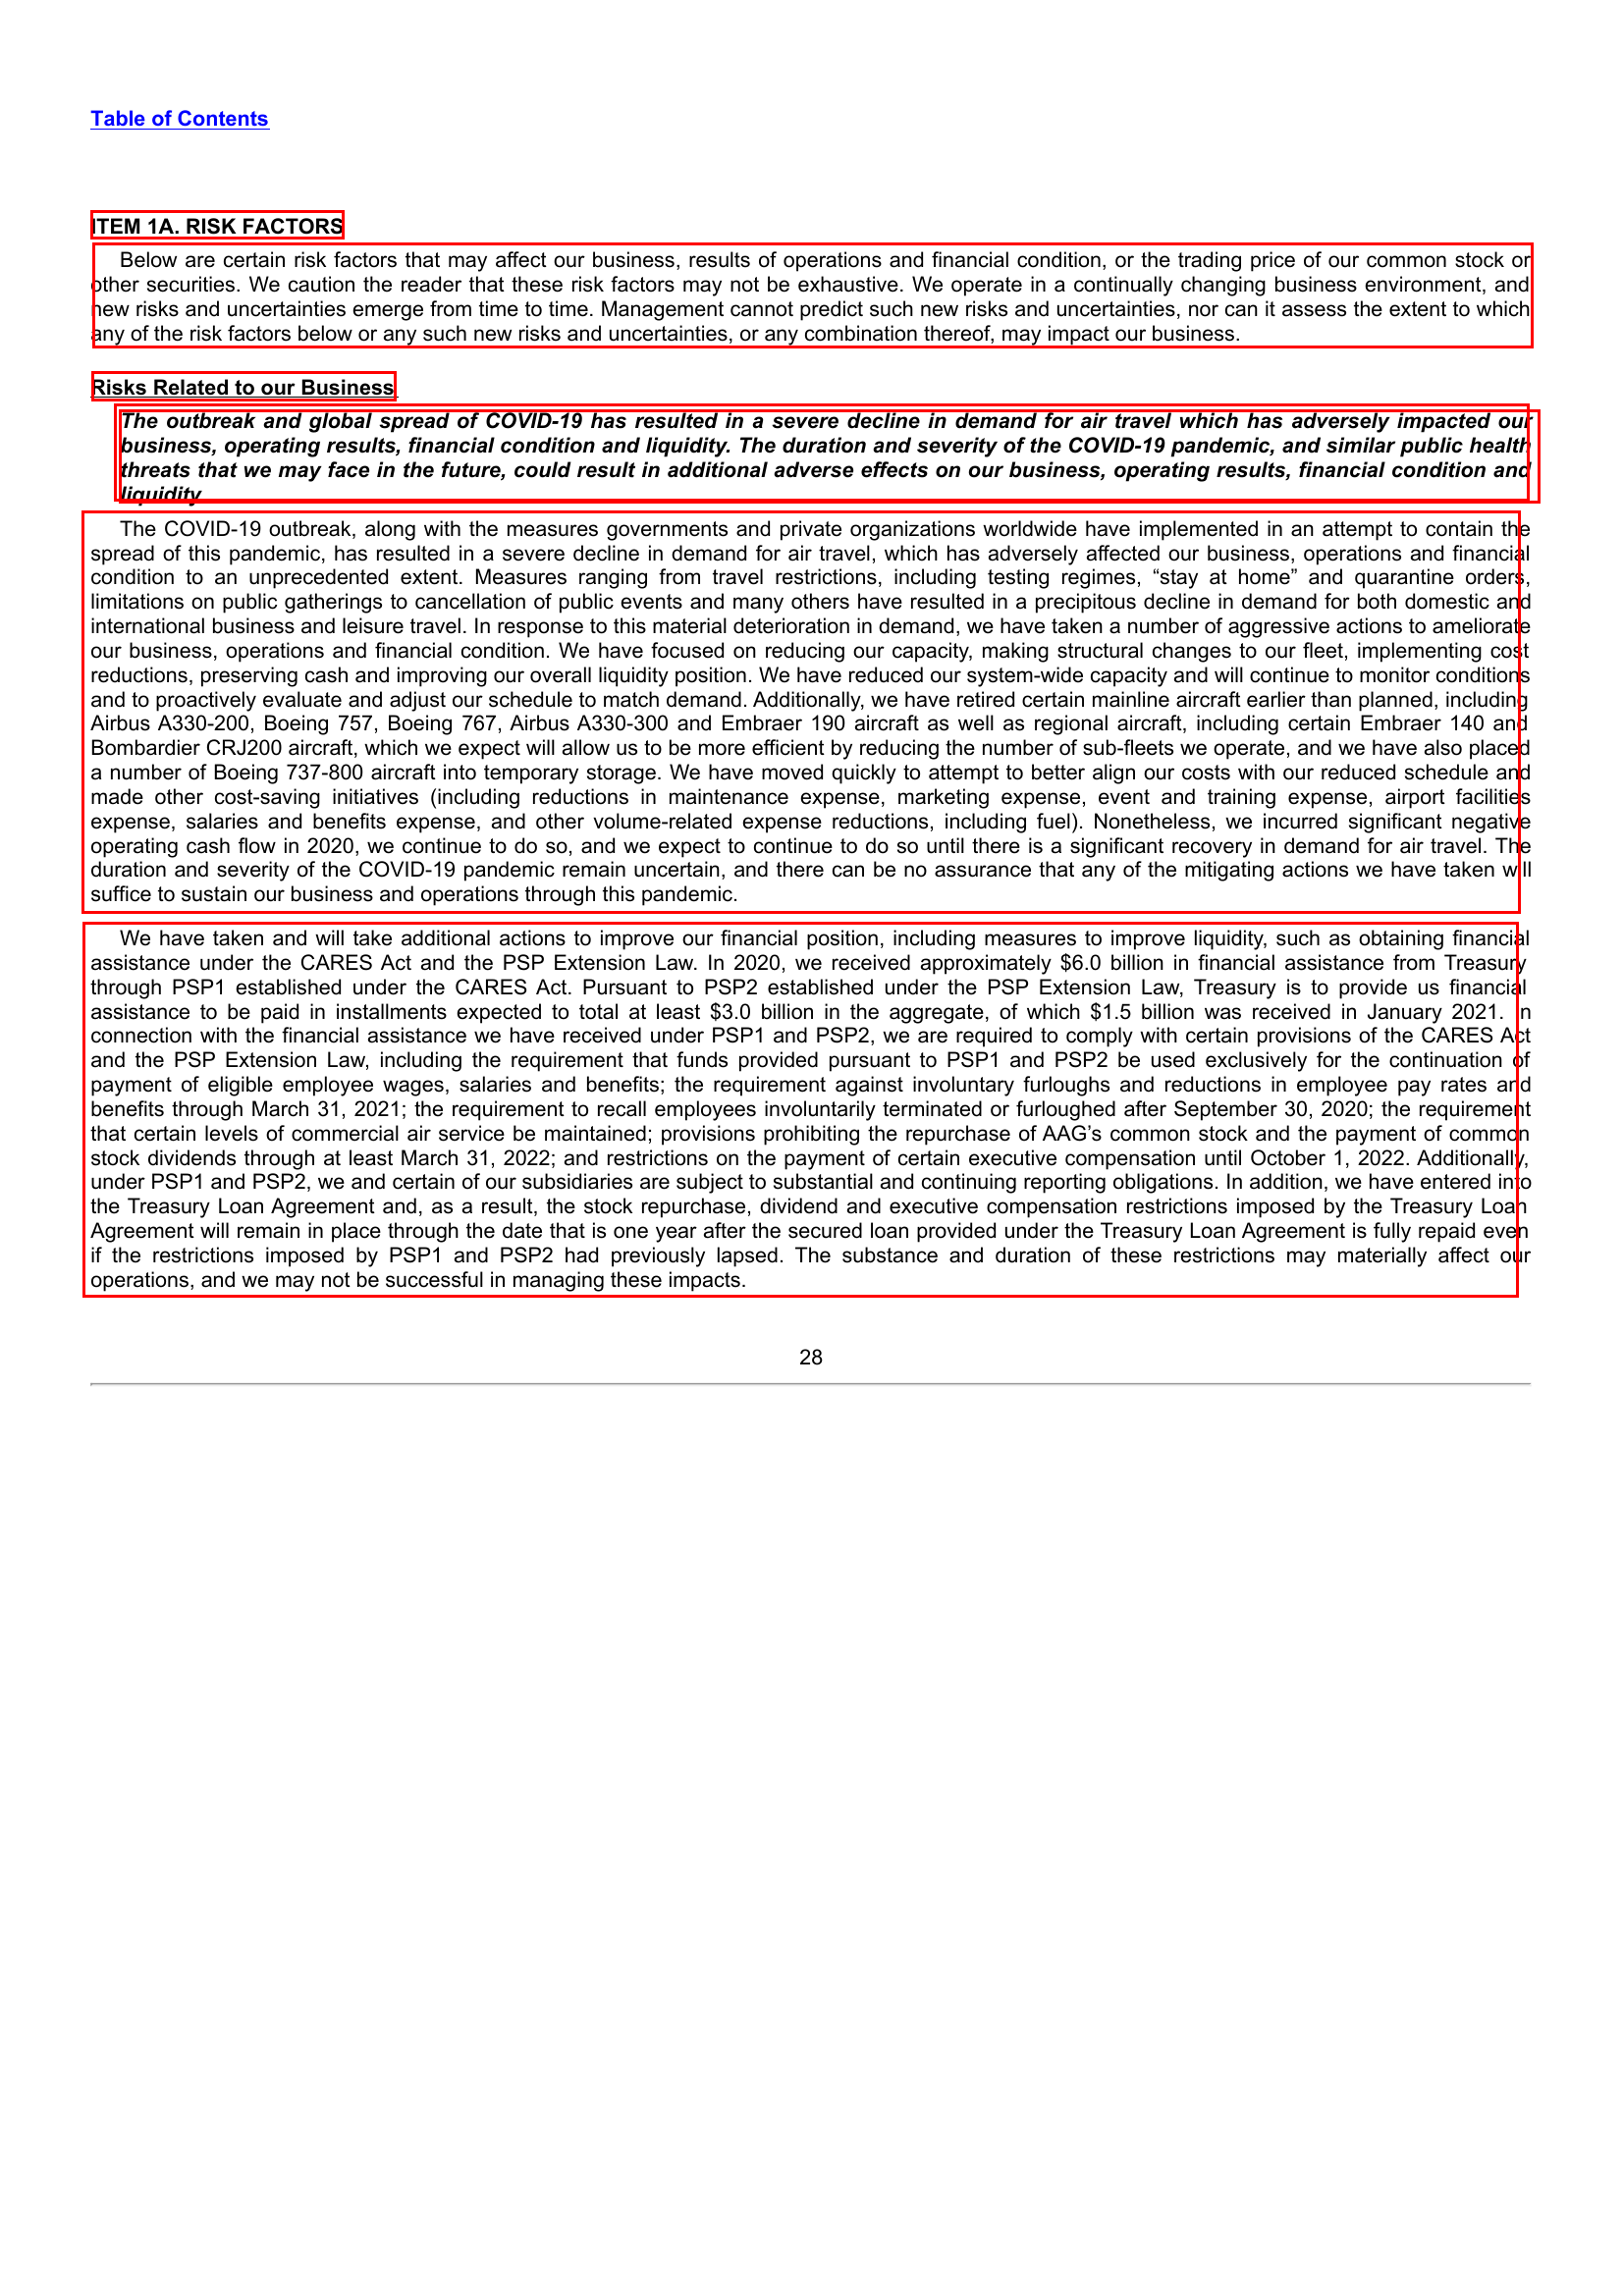

In [38]:
lp.draw_box(image, layout, box_width=3, color_map = color_map)

In [371]:
import pdfminer

text = pdfminer.high_level.extract_text('Out.pdf')

AttributeError: module 'pdfminer' has no attribute 'high_level'

In [364]:
#!pip install pdfminer

     |████████████████████████████████| 4.2MB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 1.5MB 994kB/s eta 0:00:01
  Created wheel for pdfminer: filename=pdfminer-20191125-cp37-none-any.whl size=6140082 sha256=55780a62f76cf05e870aa1146dc76f13e0f61ee7efb2ee1df3aacbdb9c3440e2
  Stored in directory: /Users/lucaskrenn/Library/Caches/pip/wheels/e1/00/af/720a55d74ba3615bb4709a3ded6dd71dc5370a586a0ff6f326
Successfully built pdfminer


In [6]:
from tika import parser

rawText = parser.from_file('Out.pdf')

rawList = rawText['content'].splitlines()

In [23]:
rawList

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'aal-20201231',
 '',
 '',
 'UNITED\tSTATES\tSECURITIES\tAND\tEXCHANGE\tCOMMISSION',
 'Washington,\tD.C.\t20549',
 '',
 'FORM10-K',
 '',
 '☒ ANNUAL\tREPORT\tPURSUANT\tTO\tSECTION\t13\tOR\t15(d)\tOF\tTHE\tSECURITIES\tEXCHANGE\tACT\tOF\t1934',
 'For\tthe\tFiscal\tYear\tEnded\tDecember\t31,\t2020',
 '',
 '☐ TRANSITION\tREPORT\tPURSUANT\tTO\tSECTION\t13\tOR\t15(d)\tOF\tTHE\tSECURITIES\tEXCHANGE\tACT\tOF\t1934',
 'For\tthe\tTransition\tPeriod\tFrom\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tto\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t',
 '',
 'Commission\tfile\tnumber\t1-8400',
 '',
 'American\tAirlines\tGroup\tInc.',
 '(Exact\tname\tof\tregistrant\tas\tspecified\tin\tits\tcharter)',
 '',
 'Delaware 75-1825172',
 '(State\tor\tother\tjurisdiction\tof\tincorporation\tor\torganization) (I.R.S.\tEmployer\tIdentification\t

In [24]:
result = [x for x in rawList if x[:4] == 'ITEM']

In [25]:
result

['ITEM\t1.\tBUSINESS',
 'ITEM\t1A.\tRISK\tFACTORS',
 'ITEM\t1B.\tUNRESOLVED\tSTAFF\tCOMMENTS',
 'ITEM\t2.\tPROPERTIES',
 'ITEM\t3.\t\tLEGAL\tPROCEEDINGS',
 'ITEM\t4.\t\tMINE\tSAFETY\tDISCLOSURES',
 'ITEM\t5.\t\t\t\tMARKET\tFOR\tAMERICAN\tAIRLINES\tGROUP’S\tCOMMON\tSTOCK,\tRELATED\tSTOCKHOLDER\tMATTERS\tAND\tISSUER\tPURCHASES',
 'ITEM\t6.\t\tSELECTED\tCONSOLIDATED\tFINANCIAL\tDATA',
 'ITEM\t7.\t\tMANAGEMENT’S\tDISCUSSION\tAND\tANALYSIS\tOF\tFINANCIAL\tCONDITION\tAND\tRESULTS\tOF\tOPERATIONS',
 'ITEM\t7A.\tQUANTITATIVE\tAND\tQUALITATIVE\tDISCLOSURES\tABOUT\tMARKET\tRISK',
 'ITEM\t8A.\tCONSOLIDATED\tFINANCIAL\tSTATEMENTS\tAND\tSUPPLEMENTARY\tDATA\tOF\tAMERICAN\tAIRLINES\tGROUP\tINC.',
 'ITEM\t8B.\tCONSOLIDATED\tFINANCIAL\tSTATEMENTS\tAND\tSUPPLEMENTARY\tDATA\tOF\tAMERICAN\tAIRLINES,\tINC.',
 'ITEM\t9.\t\tCHANGES\tIN\tAND\tDISAGREEMENTS\tWITH\tACCOUNTANTS\tON\tACCOUNTING\tAND\tFINANCIAL\tDISCLOSURE',
 'ITEM\t9A.\t\tCONTROLS\tAND\tPROCEDURES',
 'ITEM\t9B.\t\tOTHER\tINFORMATION',
 'ITEM\t10.

I wonder if this strategy will work for all forms? This would be very handy... Let's see if we can extract the necessary information:

In [26]:
matches = re.compile(r'^ITEM.*7[^A][^A]')
item7 = [matches.search(x) for x in result]

#rawList.index([-1])
[x for x in rawList if matches.search(x) != None]

['ITEM\t7.\t\tMANAGEMENT’S\tDISCUSSION\tAND\tANALYSIS\tOF\tFINANCIAL\tCONDITION\tAND\tRESULTS\tOF\tOPERATIONS']

In [27]:
idx7 = rawList.index([x for x in rawList if matches.search(x) != None][-1])

In [28]:
matches = re.compile(r'^ITEM.*8[^B][^B]')
item7 = [matches.search(x) for x in result]
[x for x in rawList if matches.search(x) != None]

['ITEM\t8A.\tCONSOLIDATED\tFINANCIAL\tSTATEMENTS\tAND\tSUPPLEMENTARY\tDATA\tOF\tAMERICAN\tAIRLINES\tGROUP\tINC.']

In [29]:
idx8 = rawList.index([x for x in rawList if matches.search(x) != None][-1])

In [30]:
item7str = ' '.join(rawList[idx7:idx8]).replace('\t', ' ')
item7str

'ITEM 7.  MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS  2020 Financial Overview Impact of Coronavirus (COVID-19)  COVID-19 has been declared a global health pandemic by the World Health Organization. COVID-19 has surfaced in nearly all regions of the world, which has driven  the  implementation of significant, government-imposed measures  to prevent or  reduce  its spread,  including  travel  restrictions,  testing regimes, closing of borders, “stay at home” orders and business closures. As a result, we have experienced an unprecedented decline in the demand for air travel, which has resulted in a material deterioration in our revenues. While our business performed largely as expected in January and February of 2020, a severe reduction in air travel starting in March 2020 resulted in our total operating revenues decreasing approximately 62% in 2020 as compared to 2019. While the  length and severity of  the reduction  in demand due to the COVID-

# Expand to All Filings For One Company

In [33]:
options = { 'quiet': '' }
start = time.time()
item7_company = []
for link in link_dict['0000006201']['Link'].values:
    pdfkit.from_url(link, 'out.pdf', options=options)
    rawText = parser.from_file('out.pdf')
    rawList = rawText['content'].splitlines()
    result = [x for x in rawList if x[:4] == 'ITEM']
    
    try:
        ##### ITEM 7
        matches = re.compile(r'^ITEM.*7[^A][^A]')
        item7 = [matches.search(x) for x in result]
        idx7 = rawList.index([x for x in rawList if matches.search(x) != None][-1])

        ##### ITEM 8
        matches = re.compile(r'^ITEM.*8[^B][^B]')
        item7 = [matches.search(x) for x in result]
        idx8 = rawList.index([x for x in rawList if matches.search(x) != None][-1])

        item7_company.append(' '.join(rawList[idx7:idx8]).replace('\t', ' '))
    except:
        item7_company.append('')
    
end = time.time()

In [34]:
print(end-start)

70.30988907814026


In [35]:
link_dict['0000006201']['Item7'] = item7_company

In [14]:
link_dict['0000006201']

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,Link,Loc7,Loc8
49,0000006201-21-000014,2021-02-17,2020-12-31,2021-02-17T17:17:57.000Z,34,10-K,001-08400,21646186,,43925703,1,1,aal-20201231.htm,10-K 2020 02.17.21,https://www.sec.gov/Archives/edgar/data/6201/0...,"[[(158292, 158310), Item 7. Management], [(167...","[[(502641, 502662), ITEM 8A. CONSOLIDATED]]"
150,0000006201-20-000023,2020-02-19,2019-12-31,2020-02-19T07:31:30.000Z,34,10-K,001-08400,20627428,,30851334,1,1,a10k123119.htm,10-K 2019 02.19.20,https://www.sec.gov/Archives/edgar/data/6201/0...,"[[(153128, 153146), Item 7. Management], [(156...","[[(414897, 414918), ITEM 8A. CONSOLIDATED]]"
225,0000006201-19-000009,2019-02-25,2018-12-31,2019-02-25T07:31:34.000Z,34,10-K,001-08400,19628071,,30572408,1,0,a10k123118.htm,10-K 2018 02.25.19,https://www.sec.gov/Archives/edgar/data/6201/0...,"[[(9505, 9523), Item 7. Management], [(12796, ...","[[(300867, 300888), ITEM 8A. CONSOLIDATED]]"
315,0000006201-18-000009,2018-02-21,2017-12-31,2018-02-21T08:02:40.000Z,34,10-K,001-08400,18627088,,27914491,1,0,a10k123117.htm,10-K,https://www.sec.gov/Archives/edgar/data/6201/0...,"[[(9554, 9572), Item 7. Management], [(13606, ...","[[(293380, 293401), ITEM 8A. CONSOLIDATED]]"
412,0001193125-17-051216,2017-02-22,2016-12-31,2017-02-22T08:01:43.000Z,34,10-K,001-08400,17627073,,24888480,1,0,d286458d10k.htm,FORM 10-K,https://www.sec.gov/Archives/edgar/data/6201/0...,"[[(9935, 9953), Item 7. Management], [(14047, ...","[[(297249, 297270), ITEM 8A. CONSOLIDATED]]"
538,0001193125-16-474605,2016-02-24,2015-12-31,2016-02-24T08:04:10.000Z,34,10-K,001-08400,161450518,,26170400,1,0,d78287d10k.htm,FORM 10-K,https://www.sec.gov/Archives/edgar/data/6201/0...,"[[(17027, 17045), Item 7. Management], [(21453...","[[(398001, 398022), ITEM 8A. CONSOLIDATED]]"
651,0001193125-15-061145,2015-02-25,2014-12-31,2015-02-25T08:02:34.000Z,34,10-K,001-08400,15645918,,39524925,1,0,d829913d10k.htm,FORM 10-K,https://www.sec.gov/Archives/edgar/data/6201/0...,"[[(16174, 16192), Item 7. Management], [(23008...","[[(452689, 452710), ITEM 8A. CONSOLIDATED]]"
750,0000006201-14-000004,2014-02-28,2013-12-31,2014-02-28T07:52:16.000Z,34,10-K,001-08400,14651496,,47888955,1,0,aagaa10k-20131231.htm,10-K,https://www.sec.gov/Archives/edgar/data/6201/0...,"[[(15590, 15608), Item 7. Management], [(23363...",[]


# Extend to All Companies

In [8]:
options = { 'quiet': '' }

counter = 0
for company in list(link_dict.keys()):
    
    now = datetime.now()
    print(counter, ' - ', now.strftime("%H:%M:%S"))
    item1a_company = []
    item7_company = []
    for link in link_dict[company]['Link'].values:
        try:
            pdfkit.from_url(link, 'out.pdf', options=options)
            
        except:
            item1a_company.append('')
            item7_company.append('')
            continue
            
        rawText = parser.from_file('out.pdf')
        rawList = rawText['content'].splitlines()
        result = [x for x in rawList if re.match('ITEM', x[:4], re.IGNORECASE)]
        
        try:
            ##### ITEM 1A
            matches = re.compile(r'^ITEM.*1(A| A)', re.IGNORECASE)
            #item7 = [matches.search(x) for x in result]
            idx1a = rawList.index([x for x in rawList if matches.search(x) != None][-1])

            ##### ITEM 1B
            matches = re.compile(r'^ITEM.*1(B| B)', re.IGNORECASE)
            #item7 = [matches.search(x) for x in result]
            idx1b = rawList.index([x for x in rawList if matches.search(x) != None][-1])
            
            item1a_company.append(' '.join(rawList[idx1a:idx1b]).replace('\t', ' '))
        
        except:
            item1a_company.append('')

        try:
            
            ##### ITEM 7
            matches = re.compile(r'^ITEM.*7[^A][^A]', re.IGNORECASE)
            #item7 = [matches.search(x) for x in result]
            idx7 = rawList.index([x for x in rawList if matches.search(x) != None][-1])

            ##### ITEM 8
            matches = re.compile(r'^ITEM.*8[^B][^B]', re.IGNORECASE)
            #item7 = [matches.search(x) for x in result]
            idx8 = rawList.index([x for x in rawList if matches.search(x) != None][-1])

            item7_company.append(' '.join(rawList[idx7:idx8]).replace('\t', ' '))
        except:
            item7_company.append('')
    
    link_dict[company]['Item1a'] = item1a_company
    link_dict[company]['Item7']  = item7_company
    
    if counter % 50 == 0:
        with open('6-link_dict.pickle', 'wb') as handle:
            pickle.dump(link_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    counter += 1

0  -  13:17:21
1  -  13:18:29
2  -  13:19:09
3  -  13:19:47
4  -  13:20:29
5  -  13:21:07
6  -  13:21:34
7  -  13:23:32
8  -  13:24:18
9  -  13:24:49
10  -  13:25:17
11  -  13:26:22
12  -  13:26:55
13  -  13:27:11
14  -  13:27:44
15  -  13:28:00
16  -  13:28:51
17  -  13:29:32
18  -  13:30:03
19  -  13:30:44
20  -  13:31:28
21  -  13:32:21
22  -  13:33:10
23  -  13:33:26
24  -  13:35:24
25  -  13:36:15
26  -  13:38:28
27  -  13:38:53
28  -  13:41:08
29  -  13:41:08
30  -  13:41:34
31  -  13:42:58
32  -  13:43:32
33  -  13:44:39
34  -  13:45:50
35  -  13:46:42
36  -  13:47:18
37  -  13:48:03
38  -  13:48:48
39  -  13:49:50
40  -  13:50:38
41  -  13:51:17
42  -  13:53:08
43  -  13:54:02
44  -  13:54:44
45  -  13:55:34
46  -  13:56:25
47  -  13:57:22
48  -  13:58:16
49  -  13:59:00
50  -  13:59:33
51  -  14:00:30
52  -  14:01:16
53  -  14:02:02
54  -  14:03:05
55  -  14:04:03
56  -  14:04:34
57  -  14:05:25
58  -  14:05:51
59  -  14:06:46
60  -  14:07:30
61  -  14:08:04
62  -  14:09:03
63

489  -  21:29:12
490  -  21:30:18
491  -  21:31:21
492  -  21:32:32
493  -  21:34:21
494  -  21:35:02
495  -  21:36:01
496  -  21:37:21
497  -  21:38:30
498  -  21:39:59
499  -  21:41:27
500  -  21:42:25
501  -  21:43:43
502  -  21:44:41
503  -  21:44:53
504  -  21:46:44
505  -  21:47:35
506  -  21:48:16
507  -  21:49:25
508  -  21:50:28
509  -  21:51:45
510  -  21:52:47
511  -  21:53:59
512  -  21:55:02
513  -  21:55:40
514  -  21:56:30
515  -  21:57:05
516  -  21:57:34
517  -  21:57:46
518  -  21:58:24
519  -  21:58:59
520  -  22:02:01
521  -  22:03:35
522  -  22:04:21
523  -  22:05:37
524  -  22:06:33
525  -  22:07:01
526  -  22:07:06
527  -  22:08:19
528  -  22:09:16
529  -  22:09:54
530  -  22:11:40
531  -  22:12:32
532  -  22:13:53
533  -  22:14:37
534  -  22:15:57
535  -  22:17:16
536  -  22:18:02
537  -  22:19:00
538  -  22:20:24
539  -  22:20:59
540  -  22:21:41
541  -  22:23:02
542  -  22:24:10
543  -  22:24:48
544  -  22:26:10
545  -  22:28:22
546  -  22:28:34
547  -  22:29:

In [18]:
link_dict['0001158449']

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,Link,Loc7,Loc8,Item7
52,0001158449-21-000036,2021-02-22,2021-01-02,2021-02-22T06:17:48.000Z,34,10-K,001-16797,21658174,,10380786,1,1,aap-20210102.htm,10-K,https://www.sec.gov/Archives/edgar/data/115844...,"[[(92292, 92310), Item 7. Management], [(10599...","[[(135183, 135200), Item 8. Financial]]",Item 7. Management’s Discussion and Analysis o...
179,0001158449-20-000035,2020-02-18,2019-12-28,2020-02-18T16:33:41.000Z,34,10-K,001-16797,20625804,,15615027,1,1,aap10k12282019secreport.htm,10-K,https://www.sec.gov/Archives/edgar/data/115844...,"[[(89201, 89219), Item 7. Management], [(99210...","[[(122041, 122058), Item 8. Financial]]",Item 7. Management’s Discussion and Analysis o...
278,0001158449-19-000043,2019-02-19,2018-12-29,2019-02-19T16:04:12.000Z,34,10-K,001-16797,19614955,,15674736,1,0,aap_10kx12292018secreport.htm,10-K,https://www.sec.gov/Archives/edgar/data/115844...,"[[(66526, 66544), Item 7. Management]]","[[(103131, 103148), Item 8. Financial]]",Item 7. Management’s Discussion and Analysis o...
387,0001158449-18-000039,2018-02-21,2017-12-30,2018-02-21T16:17:10.000Z,34,10-K,001-16797,18628626,,15046063,1,0,aap_10kx12302017.htm,10-K,https://www.sec.gov/Archives/edgar/data/115844...,"[[(64008, 64026), Item 7. Management]]","[[(103875, 103892), Item 8. Financial]]",Item 7. Management’s Discussion and Analysis o...
497,0001158449-17-000034,2017-02-28,2016-12-31,2017-02-28T17:08:31.000Z,34,10-K,001-16797,17649042,,17140639,1,0,aap_10kx12312016.htm,10-K,https://www.sec.gov/Archives/edgar/data/115844...,"[[(84532, 84550), Item 7. Management]]","[[(152790, 152807), Item 8. Financial]]",Item 7. Management’s Discussion and Analysis o...
631,0001158449-16-000299,2016-03-01,2016-01-02,2016-03-01T17:29:32.000Z,34,10-K,001-16797,161474635,,17748770,1,0,aap_10kx122016.htm,10-K,https://www.sec.gov/Archives/edgar/data/115844...,[],"[[(159224, 159241), Item 8. Financial]]",Item 7. Management’s Discussion and Analysis o...
751,0001158449-15-000063,2015-03-03,2015-01-03,2015-03-03T17:23:49.000Z,34,10-K,001-16797,15670482,,20329800,1,0,aap_10kx132015.htm,10-K 1 3 2014,https://www.sec.gov/Archives/edgar/data/115844...,[],"[[(158395, 158412), Item 8. Financial]]",Item 7. Management’s Discussion and Analysis o...
879,0001158449-14-000058,2014-02-25,2013-12-28,2014-02-25T17:13:25.000Z,34,10-K,001-16797,14641709,,20347794,1,0,aap_10kx12282013.htm,10-K,https://www.sec.gov/Archives/edgar/data/115844...,[],"[[(155007, 155024), Item 8. Financial]]",Item 7. Management’s Discussion and Analysis o...


In [9]:
with open('6-link_dict.pickle', 'wb') as handle:
    pickle.dump(link_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [467]:
list(link_dict.keys()).index(company)

765

In [ ]:
https://www.sec.gov/Archives/edgar/data/835910/000083591001000012/0000835910-01-000012.txt

In [384]:
for link in link_dict['0000006201']['Link'].values:
    pdfkit.from_url(link, 'out.pdf')
    rawText = parser.from_file('out.pdf')
    rawList = rawText['content'].splitlines()
    result = [x for x in rawList if x[:4] == 'ITEM']
    print(len(result))

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                          


22
Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                          
22
Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                          
21
Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                        

In [ ]:
response = json.loads(requests.get("https://data.sec.gov/submissions/CIK"+cik+".json", headers=heads).text)

In [1]:
badslist = []
for company in companies:
    bads = [len(x) for x in link_dict[company]['Item7'].values]
    if bads.count(0) > 0:
        badslist.append(company)

NameError: name 'companies' is not defined

In [16]:
goodslist = [x for x in link_dict.keys() if x not in badslist]

In [2]:
badslist = ['0001158449',
 '0000320193',
 '0000077551',
 '0000874501',
 '0000003333',
 '0000817473',
 '0001467373',
 '0000002135',
 '0000061478',
 '0000007084',
 '0000008670',
 '0001101215',
 '0001546640',
 '0001122304',
 '0000850693',
 '0000109563',
 '0000922864',
 '0001267238',
 '0000354190',
 '0001086222',
 '0000918160',
 '0000915913',
 '0000899051',
 '0001579241',
 '0000768251',
 '0000899866',
 '0000005133',
 '0000006951',
 '0000711065',
 '0001037868',
 '0001004434',
 '0000318154',
 '0000820027',
 '0001018724',
 '0000317093',
 '0001018840',
 '0001376610',
 '0000315293',
 '0000773910',
 '0000835910',
 '0000002969',
 '0000820313',
 '0000929887',
 '0001433270',
 '0001305168',
 '0000080737',
 '0001018963',
 '0000718877',
 '0001116521',
 '0000008818',
 '0000848865',
 '0001138234',
 '0000003673',
 '0001144215',
 '0000866787',
 '0000012927',
 '0000070858',
 '0000010456',
 '0001085734',
 '0000764478',
 '0000014930',
 '0000009892',
 '0000012355',
 '0000010795',
 '0000789073',
 '0000038777',
 '0001040441',
 '0000011860',
 '0000768835',
 '0000875045',
 '0000864328',
 '0000009263',
 '0001060021',
 '0000009389',
 '0000732713',
 '0000351346',
 '0000014272',
 '0000934612',
 '0000010427',
 '0001054374',
 '0000010081',
 '0000777001',
 '0000310569',
 '0000920448',
 '0000908255',
 '0001037540',
 '0000356028',
 '0000721371',
 '0000319687',
 '0000723612',
 '0000018230',
 '0000020171',
 '0000716133',
 '0000715096',
 '0001374310',
 '0000813828',
 '0001051470',
 '0000815097',
 '0000104599',
 '0000739708',
 '0000813672',
 '0001402057',
 '0001306830',
 '0001004440',
 '0000804753',
 '0000025191',
 '0000706539',
 '0000019353',
 '0001091667',
 '0000936395',
 '0000899652',
 '0000764065',
 '0000028412',
 '0001166691',
 '0000811156',
 '0000803014',
 '0001000736',
 '0001071739',
 '0001130310',
 '0001069353',
 '0000927628',
 '0001137411',
 '0000738076',
 '0000711404',
 '0001163165',
 '0000909832',
 '0001024305',
 '0001385187',
 '0000016732',
 '0000900075',
 '0000025445',
 '0001100682',
 '0001009672',
 '0000858877',
 '0000277948',
 '0000723254',
 '0000024491',
 '0001058290',
 '0000018532',
 '0001053112',
 '0001062047',
 '0001054833',
 '0000064803',
 '0000093410',
 '0001358071',
 '0000858339',
 '0000894315',
 '0000931336',
 '0001393612',
 '0000029534',
 '0001022079',
 '0001001082',
 '0000935703',
 '0000027996',
 '0001115222',
 '0000945764',
 '0000949039',
 '0000029905',
 '0000029915',
 '0001072342',
 '0001286681',
 '0000783280',
 '0000940944',
 '0000936340',
 '0000927066',
 '0001090012',
 '0001379895',
 '0000712515',
 '0000352947',
 '0000031462',
 '0001047862',
 '0000827052',
 '0001001250',
 '0000915389',
 '0000032604',
 '0001100962',
 '0001463101',
 '0001038339',
 '0001066107',
 '0001350031',
 '0000906107',
 '0000033213',
 '0001393744',
 '0001532063',
 '0000920522',
 '0000314808',
 '0001551182',
 '0000065984',
 '0000846909',
 '0001099800',
 '0001324424',
 '0001289490',
 '0001326801',
 '0000050341',
 '0001519751',
 '0000831259',
 '0000034408',
 '0001048695',
 '0000036966',
 '0001136893',
 '0000798354',
 '0000035527',
 '0000850209',
 '0001124198',
 '0000314132',
 '0001026214',
 '0000310522',
 '0000883569',
 '0001068002',
 '0000034903',
 '0000038074',
 '0000880430',
 '0001392522',
 '0001274494',
 '0000020520',
 '0000043300',
 '0001004155',
 '0000929987',
 '0000042293',
 '0000040545',
 '0000732485',
 '0000104889',
 '0001063393',
 '0000043362',
 '0000024741',
 '0001467858',
 '0000909954',
 '0001326380',
 '0001474735',
 '0001276520',
 '0000041077',
 '0000039911',
 '0000042542',
 '0001045309',
 '0001121788',
 '0000886982',
 '0001273441',
 '0000895812',
 '0000277135',
 '0000045012',
 '0000800459',
 '0000046080',
 '0000049196',
 '0001359841',
 '0000860730',
 '0000921847',
 '0000878736',
 '0000354950',
 '0000314727',
 '0000004447',
 '0000048039',
 '0001417398',
 '0000874766',
 '0001585689',
 '0000792985',
 '0000046640',
 '0000793952',
 '0000859737',
 '0000773840',
 '0000316206',
 '0000046765',
 '0000046989',
 '0000012659',
 '0000048465',
 '0000202058',
 '0000023666',
 '0001000228',
 '0001274057',
 '0001070750',
 '0000047111',
 '0000051143',
 '0000832101',
 '0000353944',
 '0000003370',
 '0001110803',
 '0000879169',
 '0000050863',
 '0000051644',
 '0001466258',
 '0001020569',
 '0000216228',
 '0000914208',
 '0000898293',
 '0001166126',
 '0000052988',
 '0001084580',
 '0000045599',
 '0000736260',
 '0000779152',
 '0000200406',
 '0000874016',
 '0000801898',
 '0000053347',
 '0000019617',
 '0000072333',
 '0000352363',
 '0000795266',
 '0001012393',
 '0001047699',
 '0000879101',
 '0001028215',
 '0001506307',
 '0001170010',
 '0001530721',
 '0000056873',
 '0000870517',
 '0001545158',
 '0001062379',
 '0000885639',
 '0000054480',
 '0000764762',
 '0001336920',
 '0000058492',
 '0000920760',
 '0000920148',
 '0001575571',
 '0001056239',
 '0000059478',
 '0000059558',
 '0001424847',
 '0000060667',
 '0000707549',
 '0000703360',
 '0001006240',
 '0000016099',
 '0000092380',
 '0001001288',
 '0001489393',
 '0001335258',
 '0001141391',
 '0000912595',
 '0001048286',
 '0000062996',
 '0000063276',
 '0000063416',
 '0000814585',
 '0000063908',
 '0000827054',
 '0000927653',
 '0001103982',
 '0000708819',
 '0000064670',
 '0001048685',
 '0000873591',
 '0000037748',
 '0000065100',
 '0000867058',
 '0001099219',
 '0000890801',
 '0000851968',
 '0001170650',
 '0001399315',
 '0000066479',
 '0001452575',
 '0001278021',
 '0000062709',
 '0001578732',
 '0001567892',
 '0000764180',
 '0000067472',
 '0001285785',
 '0001510295',
 '0000310158',
 '0000101778',
 '0000895421',
 '0001408198',
 '0000068505',
 '0000036270',
 '0001037646',
 '0000876437',
 '0000061986',
 '0000717423',
 '0001159297',
 '0000063541',
 '0000716823',
 '0000808450',
 '0001084750',
 '0000072207',
 '0000789933',
 '0000069970',
 '0001513761',
 '0000070866',
 '0001120193',
 '0001169055',
 '0000753308',
 '0000352510',
 '0001065280',
 '0000912750',
 '0000320187',
 '0000906709',
 '0001492633',
 '0001133421',
 '0001021860',
 '0000758004',
 '0001013871',
 '0000702165',
 '0001096376',
 '0001520566',
 '0001002047',
 '0000073309',
 '0000836106',
 '0000906163',
 '0000824169',
 '0000071691',
 '0000800240',
 '0000029989',
 '0001486800',
 '0001341439',
 '0000898173',
 '0000075234',
 '0000797468',
 '0001100389',
 '0001084230',
 '0000723531',
 '0001378946',
 '0001076405',
 '0000075488',
 '0000849213',
 '0000078066',
 '0000891024',
 '0000077476',
 '0000863157',
 '0001126328',
 '0000080424',
 '0000075677',
 '0000031791',
 '0000899881',
 '0001413329',
 '0000767920',
 '0000935724',
 '0001135971',
 '0000945841',
 '0000079879',
 '0000922224',
 '0000820096',
 '0001393311',
 '0000875570',
 '0001534701',
 '0001089976',
 '0000078239',
 '0001035713',
 '0000804328',
 '0000918386',
 '0000084129',
 '0001275283',
 '0000770949',
 '0000884887',
 '0000910606',
 '0000872589',
 '0001281761',
 '0000315213',
 '0001451505',
 '0000720005',
 '0001037038',
 '0000943819',
 '0000085812',
 '0000084792',
 '0001024478',
 '0000084839',
 '0000745732',
 '0001058083',
 '0000355622',
 '0000897723',
 '0001008817',
 '0000278352',
 '0000829224',
 '0000754737',
 '0000316709',
 '0000089089',
 '0000789388',
 '0001373835',
 '0001006835',
 '0000087777',
 '0001310067',
 '0000090185',
 '0000721083',
 '0000091419',
 '0000087347',
 '0001032033',
 '0000835541',
 '0000091440',
 '0000883241',
 '0001035354',
 '0000092122',
 '0000811830',
 '0001063761',
 '0000791519',
 '0000861878',
 '0000094887',
 '0000832428',
 '0000815065',
 '0000750556',
 '0000203077',
 '0000016918',
 '0000086144',
 '0000709804',
 '0000849399',
 '0000096021',
 '0001378453',
 '0000816761',
 '0001094285',
 '0000350563',
 '0000096879',
 '0000097210',
 '0000836267',
 '0000027419',
 '0001011657',
 '0000098246',
 '0000731939',
 '0000098362',
 '0000320335',
 '0000097745',
 '0001283699',
 '0000097854',
 '0001005414',
 '0001526520',
 '0000864749',
 '0000086312',
 '0001267097',
 '0000916365',
 '0001020265',
 '0000721683',
 '0000946581',
 '0001008654',
 '0001377013',
 '0001418091',
 '0001105705',
 '0000217346',
 '0001023291',
 '0000716039',
 '0000074208',
 '0001403568',
 '0000100885',
 '0000100893',
 '0001090727',
 '0000912615',
 '0001067701',
 '0000036104',
 '0000811669',
 '0000101829',
 '0001017008',
 '0000203527',
 '0000103379',
 '0001396009',
 '0001442145',
 '0000883237',
 '0001068132',
 '0000880446',
 '0000732712',
 '0000943452',
 '0001000697',
 '0001279363',
 '0000106040',
 '0000030697',
 '0000865436',
 '0001453090',
 '0000107681',
 '0001255474',
 '0000933136',
 '0000107263',
 '0000108516',
 '0001518832',
 '0001365135',
 '0000108601',
 '0000005187',
 '0001174922',
 '0000072903',
 '0000034088',
 '0000818479',
 '0000108772',
 '0000868809',
 '0000716006',
 '0001041061',
 '0000877212',
 '0001555280']